# Immersive exploratory analysis

**Activities**

* Load and process the GlassAI data
* Load and process Immersive Survey data (including the data processed by Kostas)
* Match?
* Produce descriptives and basic visualisations



## Preliminaries

Such as paths

In [1]:
%matplotlib inline
#NB I install a standard set of directories

#Get the top path
top_path = os.path.dirname(os.getcwd())

#Create the path for external data
ext_data = os.path.join(top_path,'data/external')

fig_path = os.path.join(top_path,'reports/figures')

## Load data

### Metadata

In [2]:
#Load nspl to get TTWAs
nspl = pd.read_csv(ext_data+'/NSPL_AUG_2017_UK.csv')

#And TTWA names - codes lookup
ttwa_names = pd.read_table(ext_data+'/ttwa_names_codes.txt',delimiter='\t')

ttwa_codes_names_lookup = {x:y for x,y in zip(ttwa_names['TTWA11CD'],
                                             ttwa_names['TTWA11NM'])}

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# IDBR totals for normalising
idbr = pd.read_csv(ext_data+'/idbr_business_totals.csv')

### GlassAI data

In [4]:
#Load
glass_ai = pd.read_excel(ext_data+'/17_11_2017_company_list_glassai.xlsx')
glass_ai.head()

glass_ai.shape

#Postcodes
glass_postcodes = pd.read_table(ext_data+'/immerse_v4_postcodes.txt',delimiter='\t',header=None)
glass_postcodes.columns=['id','postcode']

glass_ai_geo = pd.merge(glass_ai,glass_postcodes,left_on='Organization ID',right_on='id')
glass_ai_geo['postcode_top'] = [x.split(",")[0].upper() if type(x)==str else np.nan for x in glass_ai_geo.postcode]

glass_ai_geo = pd.merge(glass_ai_geo,nspl[['pcds','ttwa','lat','long']],left_on='postcode_top',right_on='pcds',how='left')
glass_ai_geo['ttwa_name'] = [ttwa_codes_names_lookup[x] if x in ttwa_codes_names_lookup.keys() else np.nan for x in glass_ai_geo['ttwa']]

### MTM survey

In [5]:
#Load data from SPSS
mtm_from_spss = pd.read_csv(ext_data+'/14_01_2018_immersive_survey.csv',encoding='latin1').iloc[:,1:]

#We still need to add the question names and responses. Need to find them.
#For some reason a couple of the columns are missing from the spss file. Load the csv file and merge

mtm_from_csv = pd.read_excel(ext_data+'/14_01_2018_immersive_survey_raw_csv.xls')

#These are the geocodes
mtm_geo_coded = pd.read_csv(ext_data+'/12_01_2018_company_list_geo_located.csv')

#Company House matches - ask Kostas to take me through this.
mtm_ch = pd.read_csv(ext_data+'/12_01_2018_company_list_ch_matches.csv')

#Data dictionary
data_dict = pd.read_excel(ext_data+'/14_01_2018_survey_data_dictionary.xlsx')

mtm_from_spss.columns=data_dict.q_name_short

In [6]:
#Combine everything and rename
mtm_all = pd.concat([mtm_from_csv.loc[:,['QQ2_1','QQ2_3']],mtm_from_spss,mtm_geo_coded,mtm_ch],axis=1)

mtm_all.rename(columns={'QQ2_1':'name','QQ2_3':'survey_postcode'},inplace=True)

In [7]:
#Uppercase 
mtm_all['survey_postcode'] = [str(x).upper() for x in mtm_all['survey_postcode']]

mtm_all = pd.merge(mtm_all,nspl[['pcds','ttwa']],left_on='survey_postcode',right_on='pcds',how='left')
mtm_all['ttwa_name']= [ttwa_codes_names_lookup[x] if x in ttwa_codes_names_lookup.keys() else np.nan for x in mtm_all['ttwa']]

In [8]:
#Now that's the survey data

**Next steps**

* GlassAI
  * Ask them for postcodes

* Basic descriptives: 
  * Company roles
  * Performance
    * Value
    * Spend / future spend
    * Growth
    * Clients
  * Favourable factors and barriers in different locations
  * Ask MTM how can we match GlassAI with the survey responses


In [9]:
survey_data = mtm_all.copy()

In [10]:
descriptives = [survey_data.loc[:,x].describe() for x in survey_data.columns]

for x,y in zip(survey_data.columns,descriptives):
    print(x)
    print('======')
    print(y)
    print('\n')

name
                  name                                               name
count              260                                                260
unique             259                                                  1
top     The Old Market  I am the best person to complete this question...
freq                 2                                                260


survey_postcode
count         260
unique        254
top       BN1 4GH
freq            4
Name: survey_postcode, dtype: object


id
count    2.600000e+02
mean     3.383727e+06
std      2.195833e+04
min      3.347648e+06
25%      3.372702e+06
50%      3.386778e+06
75%      3.402251e+06
max      3.464635e+06
Name: id, dtype: float64


name
                  name                                               name
count              260                                                260
unique             259                                                  1
top     The Old Market  I am the best person to complete this q

## EDA preliminary analysis

### Where are they?

In [11]:
# Functions

def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

def save_fig(name):
    plt.tight_layout()
    plt.savefig(fig_path+'/{name}.pdf'.format(name=name),bbox_inches='tight')


In [12]:
idbr.head()

,ttwa_name,ttwa_code,year,Advertising and marketing,All creative industries,Architecture,"Design: product, graphic and fashion design","Film, TV, video, radio and photography","IT, software and computer services","Music, performing and visual arts",Publishing,not_creative,region,is_cluster
0,Aberdeen,S22000047,2011_2014,58.0,1155.0,191.0,103.0,84.0,519.0,154.0,47.0,26250.000000,Scotland,False
1,Aberdeen,S22000047,2015_2016,65.0,1247.5,182.5,110.0,82.5,605.0,155.0,47.5,30140.000000,Scotland,False
2,Aberystwyth,W22000021,2011_2014,9.0,117.0,11.0,6.0,15.0,36.0,21.0,20.0,3078.947368,Wales,False
3,Aberystwyth,W22000021,2015_2016,NaN,120.0,NaN,NaN,NaN,NaN,NaN,NaN,3075.000000,Wales,False
4,Alness and Invergordon,S22000048,2011_2014,3.0,29.0,8.0,NaN,3.0,9.0,4.0,NaN,966.666667,Scotland,False


In [13]:
#Load GlassAI datasets where we have locations (and excluding Jersey Islands)
glass_ai_locations = glass_ai_geo.dropna(axis=0,
                                         subset=['postcode_top']).loc[glass_ai_geo.lat<95,:].reset_index(drop=False)



In [14]:
sectors = list(glass_ai_locations.Sector.value_counts()[:4].index)+['Other']

accent_colors = plt.cm.get_cmap('Pastel1').colors[:5]

color_lookup = {x:y for x,y in zip(sectors,accent_colors)}

glass_ai_locations['sector_to_map'] = [x if x in sectors[:4] else 'Other' for x in glass_ai_locations['Sector']]

In [15]:
sectors

['Technology',
 'Professional Services',
 'Non Profit and Education',
 'Media and Arts',
 'Other']

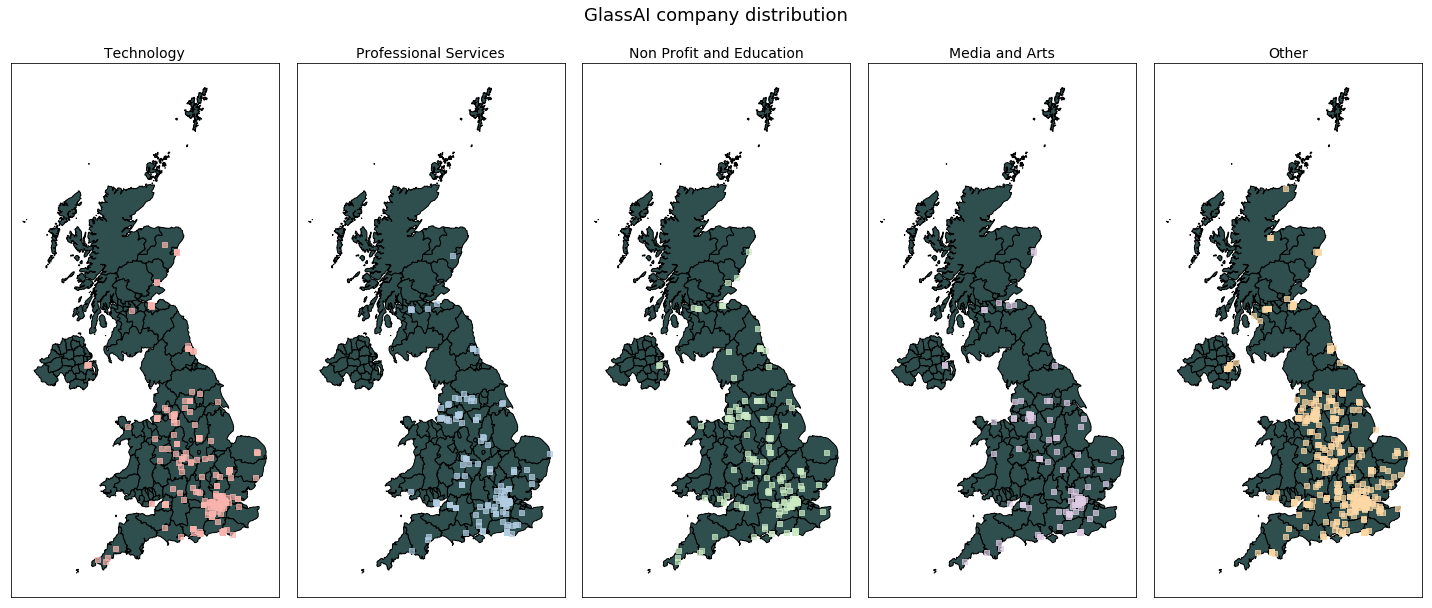

In [16]:
import geopandas as gp

uk_map = gp.read_file(ext_data+'/StatPlanet_UK/map/map.shp')


fig, ax = plt.subplots(ncols=5,figsize=(20,8))

for number in np.arange(0,5):
    
    uk_map.plot(ax=ax[number],color='darkslategrey',edgecolor='black')

    sector_orgs = glass_ai_locations.loc[glass_ai_locations.sector_to_map==sectors[number],:]
    
    ax[number].scatter(sector_orgs['long'],sector_orgs['lat'],color=color_lookup[sectors[number]],alpha=0.7,
                       marker='s',
                       s=25,
                       #edgecolor='white',
                       #linewidth=1
                      )
    ax[number].set_title(sectors[number],fontsize=14)
    
    ax[number].xaxis.set_visible(False)
    ax[number].yaxis.set_visible(False)
               

plt.subplots_adjust(wspace=0.05)

fig.suptitle('GlassAI company distribution',y=1.05,fontsize=18)

plt.tight_layout()

plt.savefig(fig_path+'/maps.pdf',bbox_inches='tight')


In [17]:
#IDBR
idbr = pd.read_csv(ext_data+'/idbr_business_totals.csv')

glass_b_count = pd.concat([idbr.loc[(
    idbr.year=='2015_2016'),['ttwa_name','All creative industries','not_creative']].set_index('ttwa_name').sum(axis=1),
                         glass_ai_geo.ttwa_name.value_counts()],axis=1)
                         
glass_b_count.columns=['all','immersive']

glass_b_count_lq = create_lq_df(glass_b_count.fillna(0))

glass_b_count_lq.columns = ['all_lq','immersive_lq']

#Combine Business counts and LQs

glass_b_count_lq = pd.concat([glass_b_count,glass_b_count_lq],axis=1)
glass_b_count_lq['immersive_share'] = 100*np.round(glass_b_count_lq['immersive']/glass_b_count_lq['immersive'].sum(),2)


glass_top_20_ttwas = glass_b_count_lq.sort_values('immersive',ascending=False)[:20]

top_20 = glass_top_20_ttwas.index

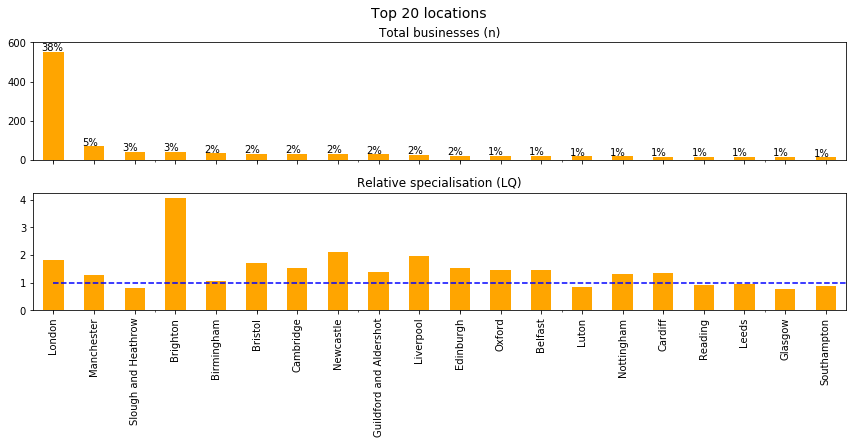

In [18]:
fig,ax = plt.subplots(nrows=2,figsize=(12,6),sharex=True)


glass_top_20_ttwas['immersive'].plot.bar(ax=ax[0],title='Total businesses (n)',color='orange')
glass_top_20_ttwas['immersive_lq'].plot.bar(ax=ax[1],title='Relative specialisation (LQ)',color='orange')

ax[1].hlines(y=1,xmin=0,xmax=20,color='blue',linestyle='--')
ax[0].set_ylim((0,600))

for num,x in enumerate(glass_top_20_ttwas.index):
    ax[0].annotate(s=str(int(glass_top_20_ttwas.loc[x,['immersive_share']]))+'%',xy=(num-0.3,
                                                                       glass_top_20_ttwas.loc[x,['immersive']]+5))

fig.suptitle('Top 20 locations',fontsize=14,y=1.02)
    
save_fig('places')

In [19]:
#TTWA sector shares

sector_ordered = glass_ai['Sector'].value_counts(ascending=False).index

ttwa_sector_shares = pd.crosstab(glass_ai_geo['Sector'],
                                 glass_ai_geo.ttwa_name).loc[sector_ordered,top_20].apply(lambda x: x/x.sum())


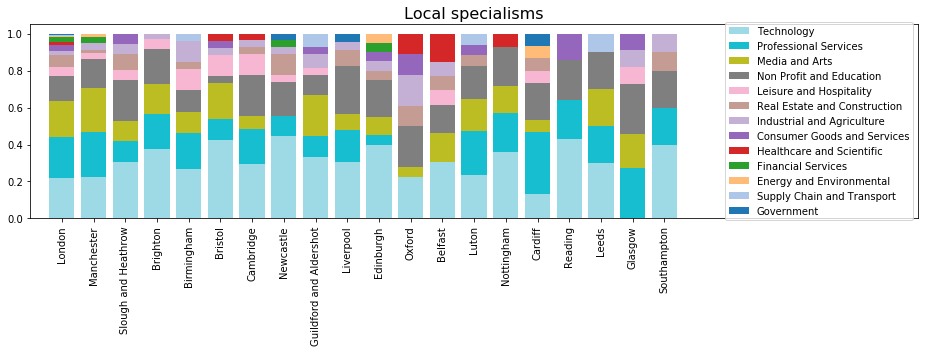

In [20]:
fig,ax = plt.subplots(figsize=(13,5))


ttwa_sector_shares.T.plot.bar(stacked=True,ax=ax,width=0.8,cmap='tab20_r')

ax.set_title('Local specialisms',fontsize=16)

ax.set_xlim(-1,27)
ax.legend(loc='center right')

save_fig('local_specialisms')

### Dweeby coverage point

Are some locations over/under represented in the survey?


In [21]:
glass_with_survey = pd.concat([glass_ai_geo['ttwa_name'].value_counts(),
                               survey_data['ttwa_name'].value_counts()],axis=1).fillna(0)

glass_with_survey.columns=['glass_share','survey_share']

glass_with_survey_shares = 100*glass_with_survey.apply(lambda x: x/x.sum()).sort_values(
    'survey_share',ascending=False).iloc[1:,:]

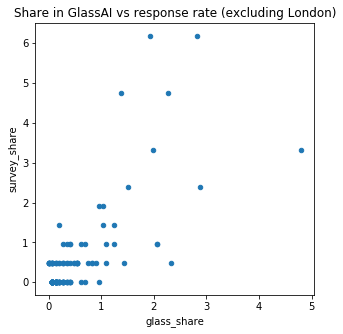

In [22]:
fig,ax = plt.subplots(figsize=(5,5))

glass_with_survey_shares.plot.scatter(x='glass_share',y='survey_share',ax=ax,
                                      title='Share in GlassAI vs response rate (excluding London)')

In [23]:
#Correlation coefficient excluding London
glass_with_survey_shares.iloc[1:,:].corr()

,glass_share,survey_share
glass_share,1.000000,0.698503
survey_share,0.698503,1.000000


## Key variables

In [24]:
#np.sum(survey_data.ttwa_name.isna())

survey_data.ttwa_name.value_counts()[:10]

London                     65
Liverpool                  13
Brighton                   13
Belfast                    10
Bristol                    10
Manchester                  7
Guildford and Aldershot     7
Edinburgh                   5
Slough and Heathrow         5
Sheffield                   4
Name: ttwa_name, dtype: int64

In [25]:
#Age
print(survey_data.q15_company_incorporation.median())
100%np.sum(survey_data.q15_company_incorporation>2011)/len(survey_data)

2012.0


0.38461538461538464

In [26]:
#Employee numbers
survey_data.q16_employees.value_counts()

survey_data_sizes = pd.Series([
    '0_single worker' if x=='0' else '1_micro' if x in [
        '1-2','3-5','6-10'] else '2_small' if x in ['11-25','26-60'] else '3_medium' if x in [
        '51-100','101-250'] else '4_big' for x in survey_data.q16_employees]).value_counts(normalize=True)

100*survey_data_sizes


1_micro            56.153846
4_big              17.692308
2_small             9.615385
0_single worker     8.846154
3_medium            7.692308
dtype: float64

In [27]:
#Turnover

100*survey_data.q19_turnover.value_counts(normalize=True)

Between Â£100k and Â£500k    18.461538
Pre-revenue                  14.230769
Between Â£50k and Â£100k     11.923077
Between Â£1m and Â£5m        11.538462
Under Â£50k                  11.153846
Prefer not to say            11.153846
Over Â£25m                    9.230769
Between Â£500k and Â£1m       8.076923
Between Â£10m and Â£25m       3.461538
Between Â£5m and Â£10m        0.769231
Name: q19_turnover, dtype: float64

### What is their role?

In [28]:
role_data = survey_data.loc[:,['q3_role_' in x for x in survey_data.columns]]
role_data_bin = role_data.applymap(lambda x: 1 if x!='No' else 0)

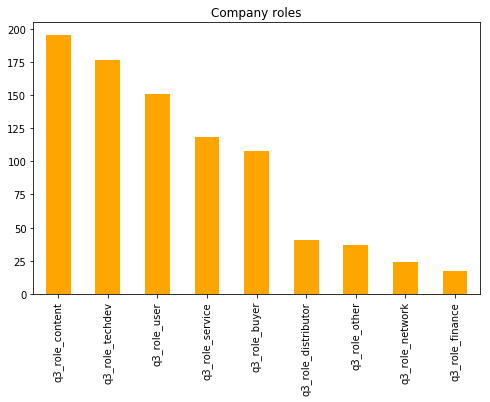

In [29]:
fig,ax = plt.subplots(figsize=(8,5))

#Roles
role_data_bin.sum().sort_values(ascending=False).plot.bar(ax=ax,color='orange',title='Company roles')

In [30]:
#from itertools import product


role_mix_df = pd.DataFrame(columns=role_data_bin.columns,index=role_data_bin.columns)

extracted=[]

for x in role_data_bin.columns:
    for y in role_data_bin.columns:
        ct = pd.crosstab(role_data_bin[x],role_data_bin[y])
        role_mix_df.loc[x,y] = ct.iloc[1,1]/np.max([role_data_bin[x].sum(),role_data_bin[y].sum()])
        role_mix_df.loc[y,x] = ct.iloc[1,1]/np.max([role_data_bin[x].sum(),role_data_bin[y].sum()])
            
        #    extracted.append([x,y])
            
role_mix_df = role_mix_df.fillna(0)

Text(0.5,1,'Role overlap')

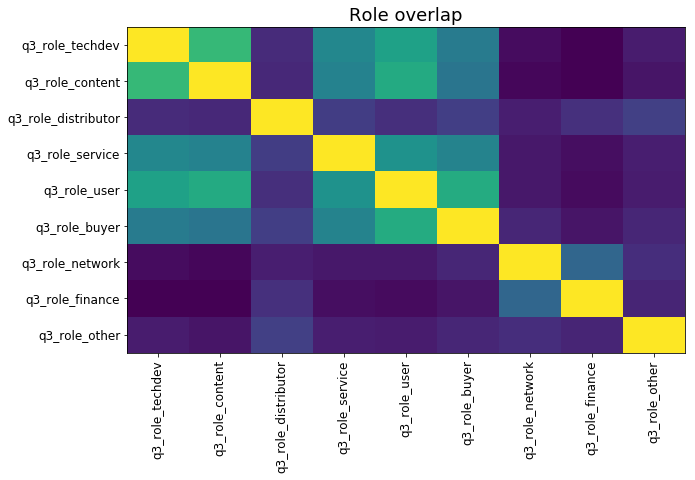

In [31]:
fig,ax = plt.subplots(figsize=(10,6))

ax.imshow(role_mix_df,aspect='auto')


ax.set_xticks(np.arange(len(role_mix_df.columns)))
ax.set_xticklabels(role_mix_df.columns,rotation=90,size=12)

ax.set_yticks(np.arange(len(role_mix_df.columns)))
ax.set_yticklabels(role_mix_df.columns,size=12)

ax.set_title('Role overlap',size=18)

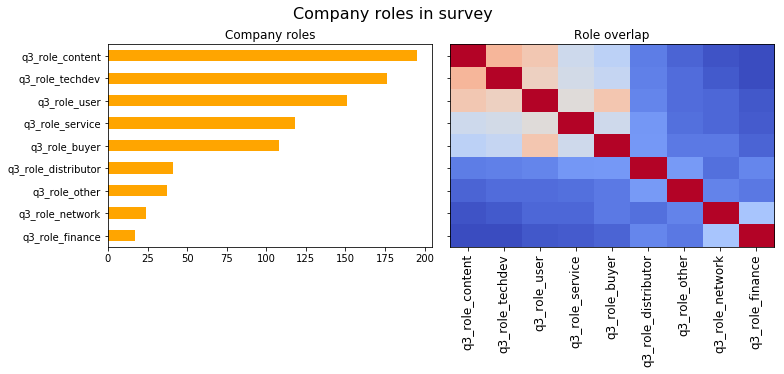

In [32]:
fig,ax = plt.subplots(ncols=2,figsize=(11,5),sharey='col')

#Roles

ordered_roles = role_data_bin.sum().sort_values(ascending=False).index

role_data_bin.sum().sort_values(ascending=True).plot.barh(ax=ax[0],color='orange',title='Company roles')

#Role mix
ax[1].imshow(role_mix_df.loc[ordered_roles,ordered_roles],aspect='auto',cmap='coolwarm')


ax[1].set_xticks(np.arange(len(ordered_roles)))
ax[1].set_xticklabels(ordered_roles,rotation=90,size=12)

ax[1].set_yticks(np.arange(len(ordered_roles)))
ax[1].set_yticklabels(['' for x in ordered_roles],size=12)

ax[1].set_title('Role overlap',size=12)

plt.subplots_adjust(wspace=0.05)

fig.suptitle('Company roles in survey',fontsize=16,y=1.03)

save_fig('roles_survey')


In [33]:
core_roles = ['q3_role_techdev','q3_role_content','q3_role_distributor']
market_roles = ['q3_role_buyer']

is_core = [role_data_bin.loc[number,core_roles].sum()>0 for number in np.arange(0,len(role_data_bin))]
is_market =[role_data_bin.loc[number,market_roles].sum()>0 for number in np.arange(0,len(role_data_bin))]

In [34]:
is_only_core = [x and not y for x,y in zip(is_core,is_market)]
is_only_market = [y and not x for x,y in zip(is_core,is_market)]

In [35]:
#Revenue from immersive
100*survey_data[is_only_core].q21_immersive_turnover.value_counts(normalize=True)

100%      28.776978
0-10%     23.741007
None      11.510791
51-75%    10.071942
11-25%     9.352518
76-99%     8.633094
26-50%     7.913669
Name: q21_immersive_turnover, dtype: float64

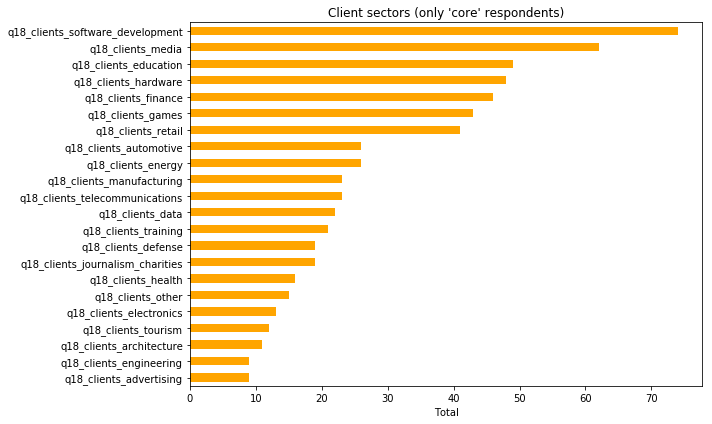

In [38]:
fig,ax = plt.subplots(figsize=(10,6))

process_question('q18_clients')[1][is_only_core].sum().sort_values(ascending=True).plot.barh(
    ax=ax,
    color='orange',title='Client sectors (only \'core\' respondents)')

ax.set_xlabel('Total')

save_fig('clients')



### What is their performance
* Way in which IE creates value for users
* Clients, exports, prospects

In [39]:
def process_question(var_name,var_type='binary'):
    '''
    This function turns a variable into counts. 
    
    '''
    if var_type=='binary':
    
        data = survey_data.loc[:,[var_name in x for x in survey_data.columns]]
        data_bin = data.applymap(lambda x: 1 if x !='No' else 0)
        
    elif var_type=='likert':
        data = survey_data.loc[:,[var_name in x for x in survey_data.columns]]
        data_bin = data.applymap(lambda x: 1 if x=='Very important' else 0)
        
    
    return([data,data_bin])
    

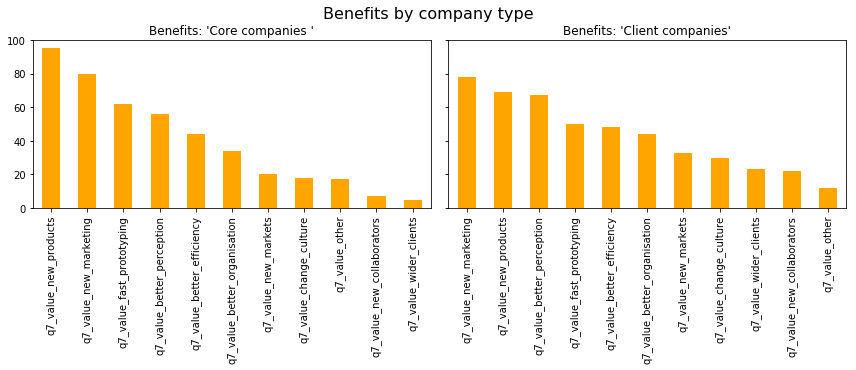

In [40]:
benefits_bin = process_question('q7_value')[1]

fig,ax = plt.subplots(ncols=2,figsize=(12,5),sharey=True)

#Benefits obtained
benefits_bin[is_only_core].sum().sort_values(ascending=False).plot.bar(ax=ax[0],color='orange',
                                                                       title='Benefits: \'Core companies \'')
benefits_bin[is_market].sum().sort_values(ascending=False).plot.bar(ax=ax[1],color='orange',
                                                                    title='Benefits: \'Client companies\'')

plt.tight_layout()

fig.suptitle('Benefits by company type',size=16,y=1.02)

save_fig('benefits_type')

In [41]:
for x in survey_data.columns:
    print(x)

name
survey_postcode
id
name
q3_market_role_vr_techdev
q3_market_role_ar_techdev
q3_market_role_other_ie_techdev
q3_market_role_vr_content
q3_market_role_ar_content
q3_market_role_other_ie_content
q3_market_role_vr_distributor
q3_market_role_ar_distributor
q3_market_role_other_ie_distributor
q3_market_role_vr_services
q3_market_role_ar_services
q3_market_role_other_ie_services
q3_market_role_vr_user
q3_market_role_ar_user
q3_market_role_other_ie_user
q3_market_role_vr_buyer
q3_market_role_ar_buyer
q3_market_role_other_ie_buyer
q3_market_role_vr_network
q3_market_role_ar_network
q3_market_role_other_ie_network
q3_market_role_vr_finance
q3_market_role_ar_finance
q3_market_role_other_ie_finance
q3_market_role_vr_other
q3_market_role_ar_other
q3_market_role_other_ie_other
q3_market_role_vr_none
q3_market_role_ar_none
q3_market_role_other_ie_none
q4_product_hardware
q4_product_software
q4_product_application
q4_product_content
q4_product_service
q4_product_other
q5_immersive_use
q7_value_ne

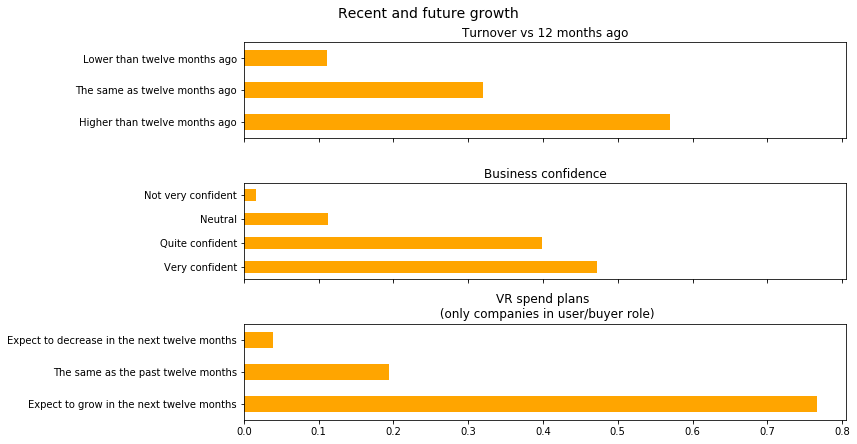

In [42]:
fig,ax = plt.subplots(nrows=3,figsize=(12,6),sharex=True)


survey_data[
    'q20_growth'].value_counts(normalize=True).plot.barh(ax=ax[0],color='orange',title='Turnover vs 12 months ago')
survey_data[
    'q22_business_confidence'].value_counts(normalize=True).plot.barh(ax=ax[1],color='orange',title='Business confidence')
survey_data.loc[
    is_market,'q26_future_spend_vr'].value_counts(normalize=True).plot.barh(ax=ax[2],color='orange',
                                                             title='VR spend plans \n (only companies in user/buyer role)')

fig.suptitle('Recent and future growth',fontsize=14,y=1.02)

save_fig('prospects')

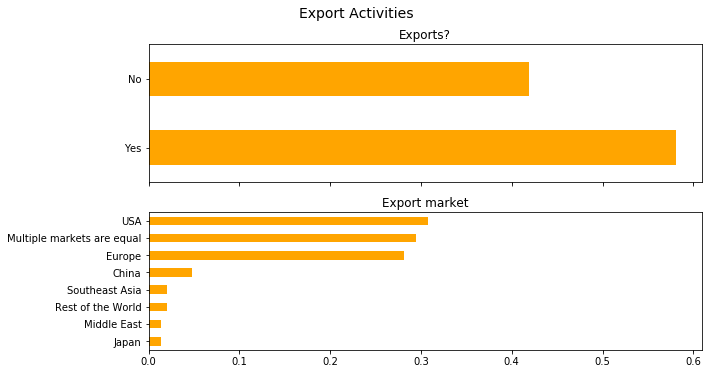

In [43]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(10,5))

survey_data.loc[:,'q8_immersive_export'].value_counts(normalize=True).plot.barh(ax=ax[0],color='orange',
                                                                                      title='Exports?')
survey_data.loc[:,'q9_export_market'].value_counts(normalize=True).sort_values(ascending=True).plot.barh(ax=ax[1],color='orange',
                                                                                   title='Export market')

fig.suptitle('Export Activities',fontsize=14,y=1.03)


save_fig('exports')

### What are the local advantages in different locations ?

* Includes access to finance


In [44]:
#Get sorted indices
local_factors_sorted = pd.concat([survey_data.reset_index(drop=True)['ttwa_name'],
                             process_question(
                                 'q10_local_factors',var_type='likert')[1].reset_index(drop=True)],axis=1).groupby(
    'ttwa_name').sum().mean(axis=0).sort_values(ascending=False).index

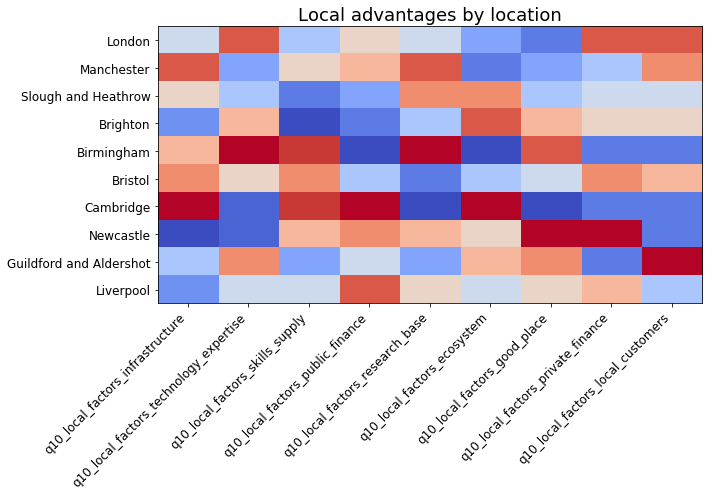

In [45]:
#Place ecosystem
place_ecosystem = pd.concat([survey_data.reset_index(drop=True)['ttwa_name'],
                             process_question(
                                 'q10_local_factors',var_type='likert')[1].reset_index(drop=True)],axis=1).groupby(
    'ttwa_name').sum().apply(lambda x:x/x.sum(),axis=1).loc[top_20[:10],local_factors_sorted]

fig,ax = plt.subplots(figsize=(10,7))


plt.imshow(place_ecosystem.rank(axis=0)[local_factors_sorted],cmap='coolwarm',aspect='auto')

ax.set_yticks(np.arange(len(place_ecosystem)))
ax.set_yticklabels(place_ecosystem.index,size=12)

ax.set_xticks(np.arange(len(place_ecosystem.columns)))
ax.set_xticklabels(place_ecosystem.columns,rotation=45,ha='right',size=12)

ax.set_title('Local advantages by location',size=18)

save_fig('local_advantages')


In [46]:
#Barrier questions
q14_questions = [x for x in survey_data.columns if 'q14' in x]

ecosystem_questions = [0,1,2,3,4,5,6,7,8]

selected_questions = [x for num,x in enumerate(q14_questions) if num in ecosystem_questions]

not_local_questions = [x for num,x in enumerate(q14_questions) if num not in ecosystem_questions]

In [47]:
#Get sorted indices
local_barriers_sorted = pd.concat([survey_data.reset_index(drop=True)['ttwa_name'],
                             process_question(
                                 'q14_barriers',var_type='binary')[1].reset_index(drop=True)],axis=1).groupby(
    'ttwa_name').sum()[selected_questions].mean(axis=0).sort_values(ascending=False).index

#Place ecosystem
place_barriers = pd.concat([survey_data.reset_index(drop=True)['ttwa_name'],
                             process_question(
                                 'q14_barriers',var_type='binary')[1].reset_index(drop=True)],axis=1).groupby(
    'ttwa_name').sum().apply(lambda x:x/x.sum(),axis=1)[selected_questions].loc[top_20[:10],:]

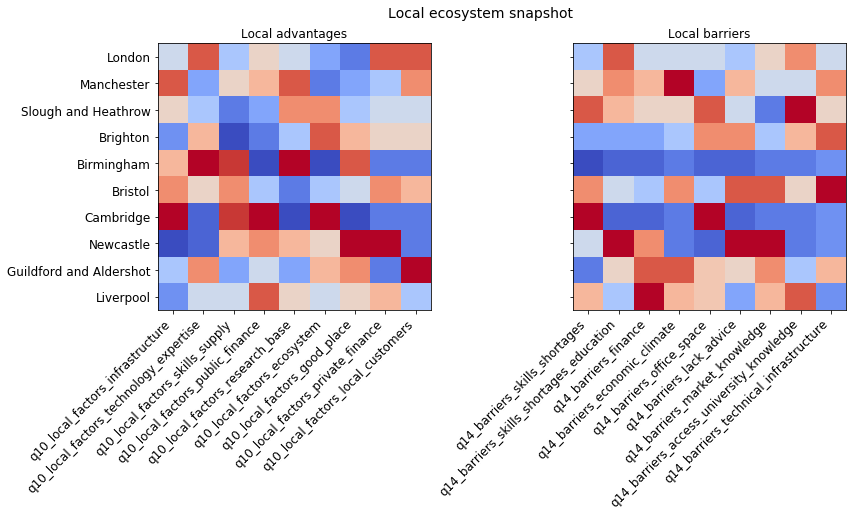

In [48]:
fig,ax = plt.subplots(figsize=(12,7),ncols=2,sharey=True)


ax[0].imshow(place_ecosystem.rank(axis=0)[local_factors_sorted],cmap='coolwarm',aspect='auto')
ax[1].imshow(place_barriers.rank(axis=0)[local_barriers_sorted],cmap='coolwarm',aspect='auto')

#Axes and title for first heatmap
ax[0].set_yticks(np.arange(len(place_barriers)))
ax[0].set_yticklabels(place_barriers.index,size=12)

ax[0].set_xticks(np.arange(len(place_ecosystem.columns)))
ax[0].set_xticklabels(place_ecosystem.columns,rotation=45,ha='right',size=12)
ax[0].set_title('Local advantages')

#Axes and barriers for second heatmap

ax[1].set_xticks(np.arange(len(place_barriers.columns)))
ax[1].set_xticklabels(local_barriers_sorted,rotation=45,ha='right',size=12)
ax[1].set_title('Local barriers')

fig.suptitle('Local ecosystem snapshot',
             y=1.02,x=0.56,
             fontsize=14)
plt.subplots_adjust(wspace=0.1)

plt.tight_layout()

plt.savefig(fig_path+'/ecosystems_snapshot.pdf',bbox_inches='tight')


In [49]:
#Identify general barriers (all companies)

not_only_core = [not x for x in is_only_core]

general_barriers_count = process_question(
    'q14_barriers',var_type='binary')[1].sum()[not_local_questions]

#general_barriers_sorted = general_barriers_count.sort_values(ascending=False)/np.sum(general_barriers_count)

#Identify general barriers (core companies)
general_barriers_core = process_question(
    'q14_barriers',var_type='binary')[1][is_only_core].sum()[not_local_questions]

general_barriers = pd.concat([general_barriers_count,general_barriers_core],axis=1)

general_barriers.columns=['All companies','Only core']

general_barriers['share_all_companies'] = general_barriers['All companies']/260
general_barriers['share_all_core'] = general_barriers['Only core']/np.sum(not_only_core)


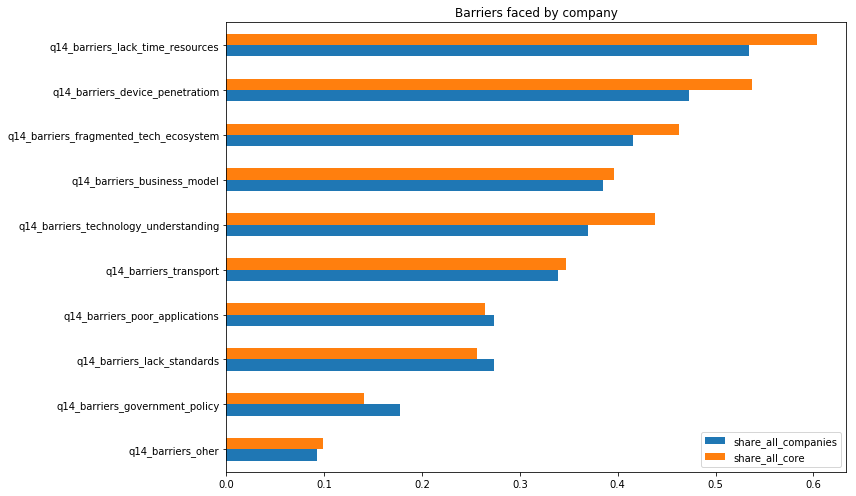

In [50]:
fig,ax = plt.subplots(figsize=(12,7))

general_barriers[['share_all_companies','share_all_core']].sort_values(
    'share_all_companies').plot.barh(ax=ax,title='Barriers faced by company')

save_fig('general_barriers')